## NEON data

Data downloaded from https://data.neonscience.org/ using api at https://data.neonscience.org/data-api/. More useful information at: https://data.neonscience.org/data-products/DP1.00094.001 Metadata and map of field sites at: https://www.neonscience.org/field-sites/explore-field-sites

Python/API: https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-intro-requests-py

Downloading: https://www.neonscience.org/resources/learning-hub/tutorials/download-explore-neon-data

Cleaning: https://www.neonscience.org/resources/learning-hub/tutorials/clean-neon-ais-data

Cite provisional data as:
NEON (National Ecological Observatory Network). Soil water content and water salinity (DP1.00094.001), provisional data. Dataset accessed from https://data.neonscience.org/data-products/DP1.00094.001 on December 18, 2024. Data archived at [your DOI].

Cite Released data as:
NEON (National Ecological Observatory Network). Soil water content and water salinity (DP1.00094.001), RELEASE-2024. https://doi.org/10.48443/a8vy-y813. Dataset accessed from https://data.neonscience.org/data-products/DP1.00094.001/RELEASE-2024 on December 18, 2024.

In [1]:
import os
from pathlib import Path
import neonutilities as nu
import rasterio
import glob
import requests
import json
import itertools
from osgeo import gdal,osr
import matplotlib
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import h5py
# from zeep import Client, Settings
# from pprint import pprint
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.dates import DateFormatter
import matplotlib.path as mpltPath
import re
from scipy.spatial import ConvexHull
from utilsCalVal import EASEconvert
import setParams as p

In [2]:
neonPath      = '/scratch/rlohman/SMCalVal/NEON/'
fp_anciStatic = '/scratch/rlohman/static/NISAR_SM_STATIC_ANCILLARY_002.h5'
startDate     = datetime.datetime(2021,4,1)
endDate       = datetime.datetime(2024,4+1,1)+datetime.timedelta(microseconds=-1)

In [3]:
#Load landcover, crop data (200mEASEGRID) and some dem info (1kmEASEGRID)
f_a      = h5py.File(fp_anciStatic,'r')
d        = f_a['/landCover200m']
dc       = f_a['/cropmap200m']
ddem     = f_a['/dem1km']

## Get locations of appropriate NEON sites
Begin by getting the location of NEON sites with observations for data product "Soil water content and water salinity", with code: DP1.00094.001

In [4]:
SERVER = 'http://data.neonscience.org/api/v0/'
productCode = 'DP1.00094.001'
url = SERVER+'products/'+productCode
#Request the url
site_request = requests.get(url)

#Convert the request to Python JSON object
site_json = site_request.json()


In [5]:
Path(neonPath).mkdir(parents=True, exist_ok=True)
siteCodes = []
lons      = []
lats      = []
ezcs      = []
ezrs      = []
lulcs     = []
crops     = []
dems      = []
for site in site_json['data']['siteCodes']:
    siteCode = site['siteCode']
    # months   = site['availableMonths']   #also....site['availableDataUrls']

    months   = [datetime.datetime.strptime(x, '%Y-%m') for x in site['availableMonths']] #convert from YYYY-MM to datetime

    #check if this includes our time range
    if months[0]<=startDate and months[-1]+datetime.timedelta(weeks=5)>endDate:
        
        #get location
        url       = SERVER+'locations/'+siteCode
        sj        = requests.get(url).json()

        lon       = sj['data']['locationDecimalLongitude']
        lat       = sj['data']['locationDecimalLatitude']
        ezc,ezr   = EASEconvert(lon,lat,1)
        ezc       = np.ceil(ezc-0.5).astype('int')
        ezr       = np.ceil(ezr-0.5).astype('int')
        lulc      = d[ezr,ezc]
        crop      = dc[ezr,ezc]
        dem       = ddem[np.floor(ezr/5).astype('int'),np.floor(ezc/5).astype('int')]

        #for now only save crop info if cropland
        if lulc!=4:
            crop=255
        siteCodes.append(siteCode)
        lons.append(lon)
        lats.append(lat)        
        ezrs.append(ezr)
        ezcs.append(ezc)
        lulcs.append(lulc)
        crops.append(crop)
        dems.append(dem)
        # Make a directory for each site if it doesn't already exist
        Path(neonPath+siteCode).mkdir(parents=True, exist_ok=True)
    else:
        print('Station with dates outside range:',siteCode,months[0],months[-1])

numsites=len(siteCodes)
sitePages = ['https://www.neonscience.org/field-sites/'+x.lower() for x in siteCodes]

In [6]:
sites = pd.DataFrame(
    {'siteCode': siteCodes,
     'lats': lats,
     'lons': lons,
     'EASEGridRowIndex': ezrs,
     'EASEGridColumnIndex': ezcs,
     'lulc': lulcs,
     'crop': crops,
     'demstd': dems,
     'web':sitePages
    })
print(sites)
sites.to_csv(neonPath+'siteList.csv')

   siteCode       lats        lons  EASEGridRowIndex  EASEGridColumnIndex   
0      ABBY  45.762439 -122.330317             10319                27796  \
1      BARR  71.282410 -156.619360              1817                11269   
2      BART  44.063889  -71.287375             11090                52399   
3      BLAN  39.033698  -78.041788             13503                49143   
4      BONA  65.154010 -147.502580              3283                15663   
5      CLBJ  33.401230  -97.570000             16411                39731   
6      CPER  40.815536 -104.745591             12627                36272   
7      DCFS  47.161650  -99.106560              9700                38990   
8      DEJU  63.881120 -145.751360              3635                16507   
9      DELA  32.541727  -87.803877             16873                44438   
10     DSNY  28.125050  -81.436190             19310                47507   
11     GRSM  35.688960  -83.501950             15205                46512   

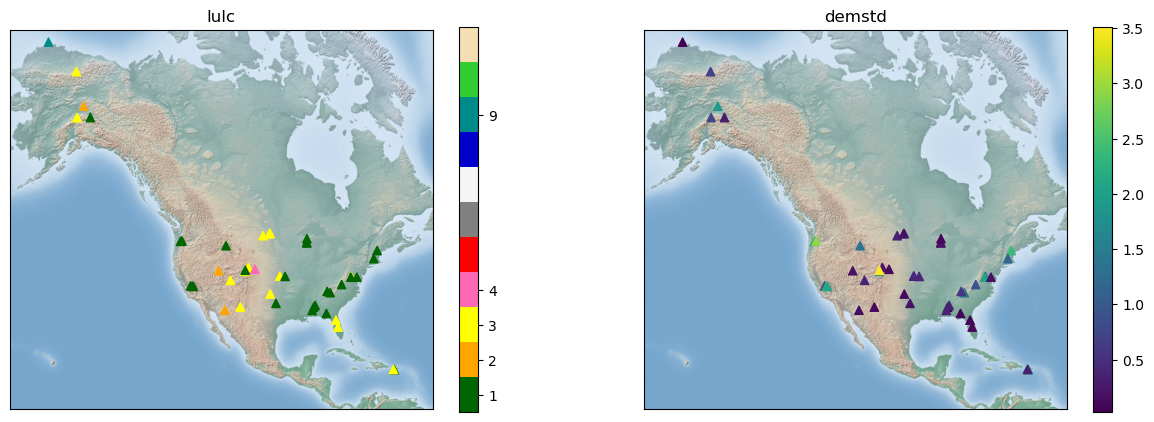

In [7]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
m = Basemap(projection='merc',llcrnrlat=min(lats)-10,urcrnrlat=max(lats)+1,llcrnrlon=min(lons)-10,urcrnrlon=max(lons)+10,lat_ts=35,resolution=None,ax=axes[0])
m.shadedrelief()
cmap=matplotlib.colors.ListedColormap(('darkgreen','orange','yellow','hotpink','red','gray','whitesmoke','mediumblue','darkcyan','limegreen','wheat'))

cb=m.scatter(lons,lats,c=lulcs,marker='^',vmin=0.5,vmax=11.5,cmap=cmap,latlon=True)
axes[0].set_title('lulc')
plt.colorbar(cb,ax=axes[0],ticks=np.unique(lulcs))
m = Basemap(projection='merc',llcrnrlat=min(lats)-10,urcrnrlat=max(lats)+1,llcrnrlon=min(lons)-10,urcrnrlon=max(lons)+10,lat_ts=35,resolution=None,ax=axes[1])
m.shadedrelief()
c=m.scatter(lons,lats,c=dems,marker='^',latlon=True)
axes[1].set_title('demstd')
plt.colorbar(c,ax=axes[1])
plt.show()


For each point, use asf_search to find track/frames that contain it, and then find list of dates for each. For now, we search one of our pre-launch ALOS-2 frames (THIS WILL CHANGE)

In [8]:
#0=WalnutGulchA, 1=WalnutGulchC,2=WalnutGulchB, 3=LittleRiver 4 = south fork
NEONpts=[34,0,34,15,41]
NEONpt = NEONpts[p.myval]


In [9]:
workDir             = p.workDir
modDirs             = (workDir+'products/retrievals/',workDir+'R4/')
# newDir              = '/scratch/rlohman/'+p.areaName+'/Path'+str(p.path)+'Frame'+str(p.frame)+'Beam'+p.beam+'logNorm/products/retrievals/'
# modDirs             = (workDir+'products/retrievals/',workDir+'R4/',newDir)

#assume list of dates is same for all modDirs
outFiles     = np.array(glob.glob(modDirs[0]+('[0-9]'*8)+'.h5'))

# #find index of begin/end of dates, assume format same for all
tmp          = re.search(r'2[0-9]{7}',outFiles[0])
inds         = tmp.span()
dates        = np.array([datetime.datetime.strptime(x[inds[0]:inds[1]],'%Y%m%d') for x in outFiles])

sort_index   = np.argsort(dates)
gcovs        = outFiles[sort_index]
dates        = dates[sort_index]
allgcovs     = np.reshape([dirName+os.path.basename(x) for dirName in modDirs for x in gcovs],[len(modDirs),len(dates)])
print(str(len(dates))+' dates in list')


60 dates in list


In [10]:
#read in first date, DSG algorithm, to construct bounding polygon

fo  = h5py.File(allgcovs[0,0],'r')
lat = fo['/science/LSAR/SME2/grids/latitude'][()]
lon = fo['/science/LSAR/SME2/grids/longitude'][()]
eci = fo['/science/LSAR/SME2/grids/EASEGridColumnIndex'][()]
eri = fo['/science/LSAR/SME2/grids/EASEGridRowIndex'][()]
ret = fo['/science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoisture'][()] #for plotting only
fo.close()

long,latg = np.meshgrid(lon,lat)
good      = np.isfinite(ret)
lat1      = latg[good].flatten()
lon1      = long[good].flatten()
points    = np.array([lat1,lon1]).T

tmp       = ConvexHull(points)
footprint = np.array([points[tmp.vertices,0],points[tmp.vertices,1]]).T #lat,lon of non-nan region

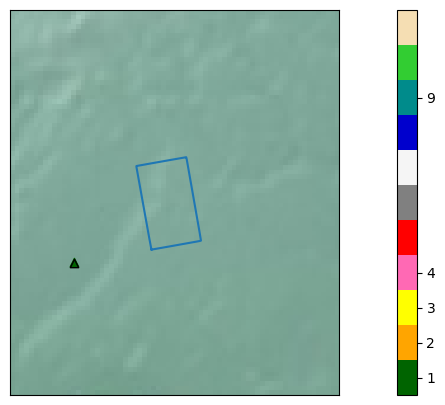

In [11]:
fig,axes = plt.subplots(figsize=(15,5))
m = Basemap(projection='merc',llcrnrlat=min(lat)-1,urcrnrlat=max(lat)+1,llcrnrlon=min(lon)-1,urcrnrlon=max(lon)+1,lat_ts=35,resolution=None)
m.shadedrelief()
cmap=matplotlib.colors.ListedColormap(('darkgreen','orange','yellow','hotpink','red','gray','whitesmoke','mediumblue','darkcyan','limegreen','wheat'))
m.plot(np.append(footprint[:,1],footprint[0,1]),np.append(footprint[:,0],footprint[0,0]),latlon=True)
cb=m.scatter(lons,lats,c=lulcs,marker='^',vmin=0.5,vmax=11.5,cmap=cmap,latlon=True)
cb=m.scatter(lons[NEONpt],lats[NEONpt],c=lulcs[NEONpt],marker='^',vmin=0.5,vmax=11.5,cmap=cmap,latlon=True,edgecolors='k')

plt.colorbar(cb,ticks=np.unique(lulcs))
plt.show()

In [12]:
url       = SERVER+'locations/'+siteCodes[NEONpt]
sj        = requests.get(url).json()
print(sj['data'].keys())
print(sj['data']['locationDecimalLatitude'])

dict_keys(['locationName', 'locationDescription', 'locationType', 'domainCode', 'siteCode', 'locationDecimalLatitude', 'locationDecimalLongitude', 'locationElevation', 'locationUtmEasting', 'locationUtmNorthing', 'locationUtmHemisphere', 'locationUtmZone', 'alphaOrientation', 'betaOrientation', 'gammaOrientation', 'xOffset', 'yOffset', 'zOffset', 'offsetLocation', 'activePeriods', 'locationProperties', 'locationParent', 'locationParentUrl', 'locationChildren', 'locationChildrenUrls'])
31.194839


In [ ]:
url = SERVER+'products/'+productCode
site_json = requests.get(url).json()
print(site_json['data']['siteCodes'][NEONpt].keys())
months   = site_json['data']['siteCodes'][NEONpt]['availableMonths']   #also....site['availableDataUrls']
urls     = site_json['data']['siteCodes'][NEONpt]['availableDataUrls']
print(months[-1])
print(urls[0])
months   = [datetime.datetime.strptime(x, '%Y-%m') for x in months] #convert from YYYY-MM to datetime

for m in months:
    if m>=startDate and m<=endDate:
        a=0
    # #check if this includes our time range
    # if months[0]<=startDate and months[-1]+datetime.timedelta(weeks=5)>endDate:
        

# #View available months and corresponding API urls, then save desired URL
# for site in product_json['data']['siteCodes']:
#     if(site['siteCode'] == SITECODE):
#         for month in zip(site['availableMonths'],site['availableDataUrls']): #Loop through the list of months and URLs
#             print(month[0],month[1]) 
#             if(month[0] == '2018-06'): #If data is available for the desired month, save the URL
#                 data_url = month[1]

s2=requests.get(urls[0]).json()
for file in s2['data']['files']:
    url = file['url']
    print(url)
    if 'extended' in url:
        print(url)
# print(s2['data'].keys())
# print(s2['data']['packages'][1])
# a=s2['data']['files'][1]
# print(type(a))
# print(s2['data']['files'])
# print(a['url'])

In [ ]:
#download current swc_depths file
#download sensor position file

#download appropriate months


In [ ]:
# print(site_json['data'].keys())

# url = SERVER+'locations/'+sites[-1]
# #Request the url
# print(url)
# site_json = requests.get(url).json()
# print(site_json['data'].keys())
# print(site_json['data']['locationDecimalLongitude'])

# #Set the Ecosystem structure (CHM) data product
# PRODUCTCODE = 'DP3.30015.001'
# #Get available months of Ecosystem structure data products for TEAK site
# #Loop through the 'dataProducts' list items (each one is a dictionary) at the site
# for product in site_json['data']['dataProducts']: 
#     #if a list item's 'dataProductCode' dict element equals the product code string
#     if(product['dataProductCode'] == PRODUCTCODE): 
#         #print the available months
#         print('Available Months: ',product['availableMonths'])
#         print('URLs for each Month:')
#         #print the available URLs
#         for url in product['availableDataUrls']:
#             print(url)

#View product code and name for every available data product
# for product in site_json['data']['dataProducts']:
#     print(product['dataProductCode'],product['dataProductTitle'])

#Make request
# product_request = requests.get(SERVER+'products/'+PRODUCTCODE)
# product_json = product_request.json()
# #Print keys for product data dictionary
# print(product_json['data'].keys())
# #Print code, name, and abstract of data product
# print(product_json['data']['productCode'])
# print(product_json['data']['productName'],'\n')
# print(product_json['data']['productAbstract'])

# #View keys of one site dictionary
# print(product_json['data']['siteCodes'][0].keys())

# #View available months and corresponding API urls, then save desired URL
# for site in product_json['data']['siteCodes']:
#     if(site['siteCode'] == SITECODE):
#         for month in zip(site['availableMonths'],site['availableDataUrls']): #Loop through the list of months and URLs
#             print(month[0],month[1]) 
#             if(month[0] == '2018-06'): #If data is available for the desired month, save the URL
#                 data_url = month[1]

In [ ]:
#for testing, just use point in middle of ALOS frame
#idx = np.array([np.linalg.norm(x) for x in eci-ezcs[NEONpt]]).argmin()
#idy = np.array([np.linalg.norm(x) for x in eri-ezrs[NEONpt]]).argmin()
idx  = np.round(len(lon)/2).astype(int)
idy  = np.round(len(lat)/2).astype(int)

retr= np.zeros([len(modDirs),len(gcovs),3])*np.nan
rete= np.zeros([len(modDirs),len(gcovs),3])*np.nan
HH  = np.zeros([len(modDirs),len(gcovs)])*np.nan
mods=('DSG','PMI','TSR')
for j in range(len(modDirs)):
    for i in range(len(dates)):
            if os.path.isfile(allgcovs[j,i]):
                fo=h5py.File(allgcovs[j,i],'r')
                dataset='/science/LSAR/SME2/grids/radarData/frequencyA/sigma0HH'
                if dataset in fo:
                    HH[j,i] =fo[dataset][idy,idx]

                for k in range(len(mods)):
                    dataset='/science/LSAR/SME2/grids/algorithmCandidates/'+mods[k]+'/soilMoisture'
                    if dataset in fo:
                        retr[j,i,k] =fo[dataset][idy,idx]
                for k in range(len(mods)):
                    dataset='/science/LSAR/SME2/grids/algorithmCandidates/'+mods[k]+'/soilMoistureUncertainty'
                    if dataset in fo:
                        rete[j,i,k] =fo[dataset][idy,idx]
                
                fo.close()
retr[retr<0] = np.nan
rete[rete<0] = np.nan
HH[HH<0]     = np.nan

In [ ]:
# Modify the file path to match the path to your zip file
# nu.stack_by_table(os.path.expanduser("~/Downloads/NEON_par.zip"))